In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import sklearn.tree

import pandas
import numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.python.keras.models import Model
from keras.utils import plot_model

import seaborn as sns
import os
import tempfile
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
oversample = SMOTE()
import joblib

In [4]:
df = pandas.read_csv('../colo_data_mar22_d032222.csv')

In [5]:
df = df[[

    'age',
    'sex',
    
    'race7',
    'educat',
    'marital',
    'occupat',

    'cig_stat',
    'cig_years',
    'cigpd_f',
    'cigar',
    'pipe',

    'fh_cancer',

    'bmi_curr',

    'asppd',
    'ibuppd',
    
    'arthrit_f',
    'bronchit_f',
    'colon_comorbidity',
    'diabetes_f',
    'divertic_f',
    'emphys_f',
    'gallblad_f',
    'hearta_f',
    'hyperten_f',
    'liver_comorbidity',
    'osteopor_f',
    'polyps_f',
    'stroke_f',

    'colo_cancer'

]]

In [6]:
# filling null values
for column in df:
    if (column == 'bmi_curr'): df[column] = df[column].fillna(df[column].mean())
    else: df[column] = df[column].fillna(df[column].mode()[0])

df.isnull().sum()

age                  0
sex                  0
race7                0
educat               0
marital              0
occupat              0
cig_stat             0
cig_years            0
cigpd_f              0
cigar                0
pipe                 0
fh_cancer            0
bmi_curr             0
asppd                0
ibuppd               0
arthrit_f            0
bronchit_f           0
colon_comorbidity    0
diabetes_f           0
divertic_f           0
emphys_f             0
gallblad_f           0
hearta_f             0
hyperten_f           0
liver_comorbidity    0
osteopor_f           0
polyps_f             0
stroke_f             0
colo_cancer          0
dtype: int64

In [7]:
y = df['colo_cancer']
X = df.drop('colo_cancer', axis = 1)

In [8]:
neg, pos = numpy.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

X, y = oversample.fit_resample(X, y)

neg, pos = numpy.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 154887
    Positive: 2359 (1.52% of total)

Examples:
    Total: 305056
    Positive: 152528 (50.00% of total)



In [9]:
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state=82)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size = 0.25, random_state=82)

train_features = numpy.array(train_features)
test_features = numpy.array(test_features)
val_features = numpy.array(val_features)

train_labels = numpy.array(train_labels)
test_labels = numpy.array(test_labels)
val_labels = numpy.array(val_labels)

train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

Training features shape: (183033, 28)
Validation features shape: (61011, 28)
Test features shape: (61012, 28)
Training labels shape: (183033,)
Validation labels shape: (61011,)
Test labels shape: (61012,)


In [11]:
XGB_decisionTree = xgb.XGBClassifier()
XGB_decisionTree = XGB_decisionTree.fit(X=train_features, y=train_labels, eval_set=[(val_features, val_labels)])

[0]	validation_0-logloss:0.55584
[1]	validation_0-logloss:0.46753
[2]	validation_0-logloss:0.38929
[3]	validation_0-logloss:0.34888
[4]	validation_0-logloss:0.30355
[5]	validation_0-logloss:0.27285
[6]	validation_0-logloss:0.24743
[7]	validation_0-logloss:0.23138
[8]	validation_0-logloss:0.21793
[9]	validation_0-logloss:0.19976
[10]	validation_0-logloss:0.18925
[11]	validation_0-logloss:0.17752
[12]	validation_0-logloss:0.16858
[13]	validation_0-logloss:0.16108
[14]	validation_0-logloss:0.15637
[15]	validation_0-logloss:0.15115
[16]	validation_0-logloss:0.14480
[17]	validation_0-logloss:0.13720
[18]	validation_0-logloss:0.13231
[19]	validation_0-logloss:0.12245
[20]	validation_0-logloss:0.11675
[21]	validation_0-logloss:0.11192
[22]	validation_0-logloss:0.11024
[23]	validation_0-logloss:0.10871
[24]	validation_0-logloss:0.10653
[25]	validation_0-logloss:0.10311
[26]	validation_0-logloss:0.10153
[27]	validation_0-logloss:0.09793
[28]	validation_0-logloss:0.09541
[29]	validation_0-loglos

In [12]:
prediction = XGB_decisionTree.predict(test_features)

print("Accuracy:",XGB_decisionTree.score(test_features, test_labels))
print()
print(metrics.classification_report(test_labels, prediction))

# metrics for positive class
Precision_pos = metrics.precision_score(test_labels, prediction, pos_label=1)
Recall = metrics.recall_score(test_labels, prediction, pos_label=1)
F1_score_pos = metrics.f1_score(test_labels, prediction, pos_label=1)

#metrics for negative class
Precision_neg = metrics.precision_score(test_labels, prediction, pos_label=0)
Specificity = metrics.recall_score(test_labels, prediction, pos_label=0)
F1_score_neg = metrics.f1_score(test_labels, prediction, pos_label=0)

# recall and specificity are opposites 

auc = metrics.roc_auc_score(test_labels, prediction)
prc = metrics.average_precision_score(test_labels, prediction)

#metrics:
print(
    "Metrics for positive class (most important)\n"+
    "Precision: "+str(Precision_pos)+
    "\nRecall: "+str(Recall)+
    "\nF1_score: "+str(F1_score_pos)
)

print()

print(
    "Metrics for negative class\n"+
    "Precision: "+str(Precision_neg)+
    "\nSpecificity: "+str(Specificity)+
    "\nF1_score: "+str(F1_score_neg)
)

print()

print(
    "AUC-ROC: "+str(auc)+
    "\nPRC: "+str(prc)
)

Accuracy: 0.9819707598505212

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     30515
           1       0.99      0.97      0.98     30497

    accuracy                           0.98     61012
   macro avg       0.98      0.98      0.98     61012
weighted avg       0.98      0.98      0.98     61012

Metrics for positive class (most important)
Precision: 0.9899663322110737
Recall: 0.9738007017083647
F1_score: 0.9818169796350171

Metrics for negative class
Precision: 0.9742366104536807
Specificity: 0.9901359986891692
F1_score: 0.9821219607333247

AUC-ROC: 0.9819683501987669
PRC: 0.9771256934106484


In [13]:
def plot_cm(labels, predictions, p=0.5):
  cm = metrics.confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('(Good) No Cancer Detected (True Negatives):', cm[0][0])
  print('(Okay) No Cancer Thought to Have Cancer (False Positives):', cm[0][1])
  print('(Bad) Cancer Thought to Have No Cancer (False Negatives):', cm[1][0])
  print('(Good) Cancer Detected (True Positives):', cm[1][1])
  print('Total Cancer Cases:', numpy.sum(cm[1]))

(Good) No Cancer Detected (True Negatives): 30214
(Okay) No Cancer Thought to Have Cancer (False Positives): 301
(Bad) Cancer Thought to Have No Cancer (False Negatives): 799
(Good) Cancer Detected (True Positives): 29698
Total Cancer Cases: 30497


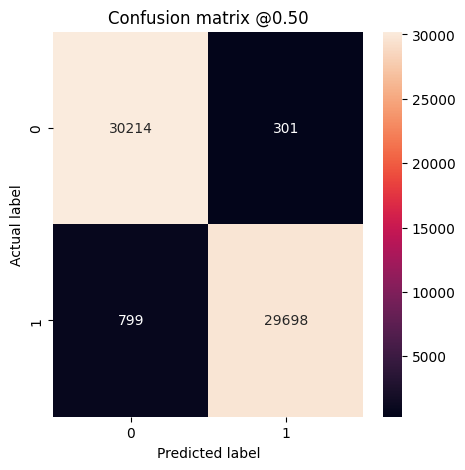

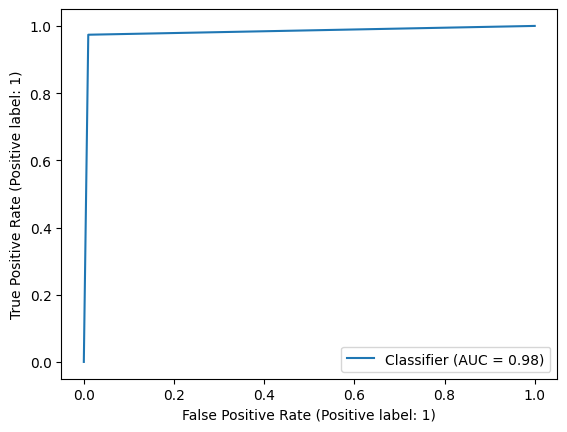

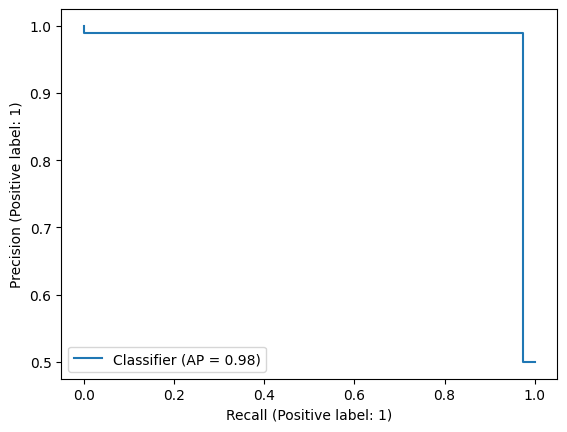

In [14]:
plot_cm(test_labels, prediction)

metrics.RocCurveDisplay.from_predictions(test_labels, prediction)
plt.show()

metrics.PrecisionRecallDisplay.from_predictions(test_labels, prediction)
plt.show()

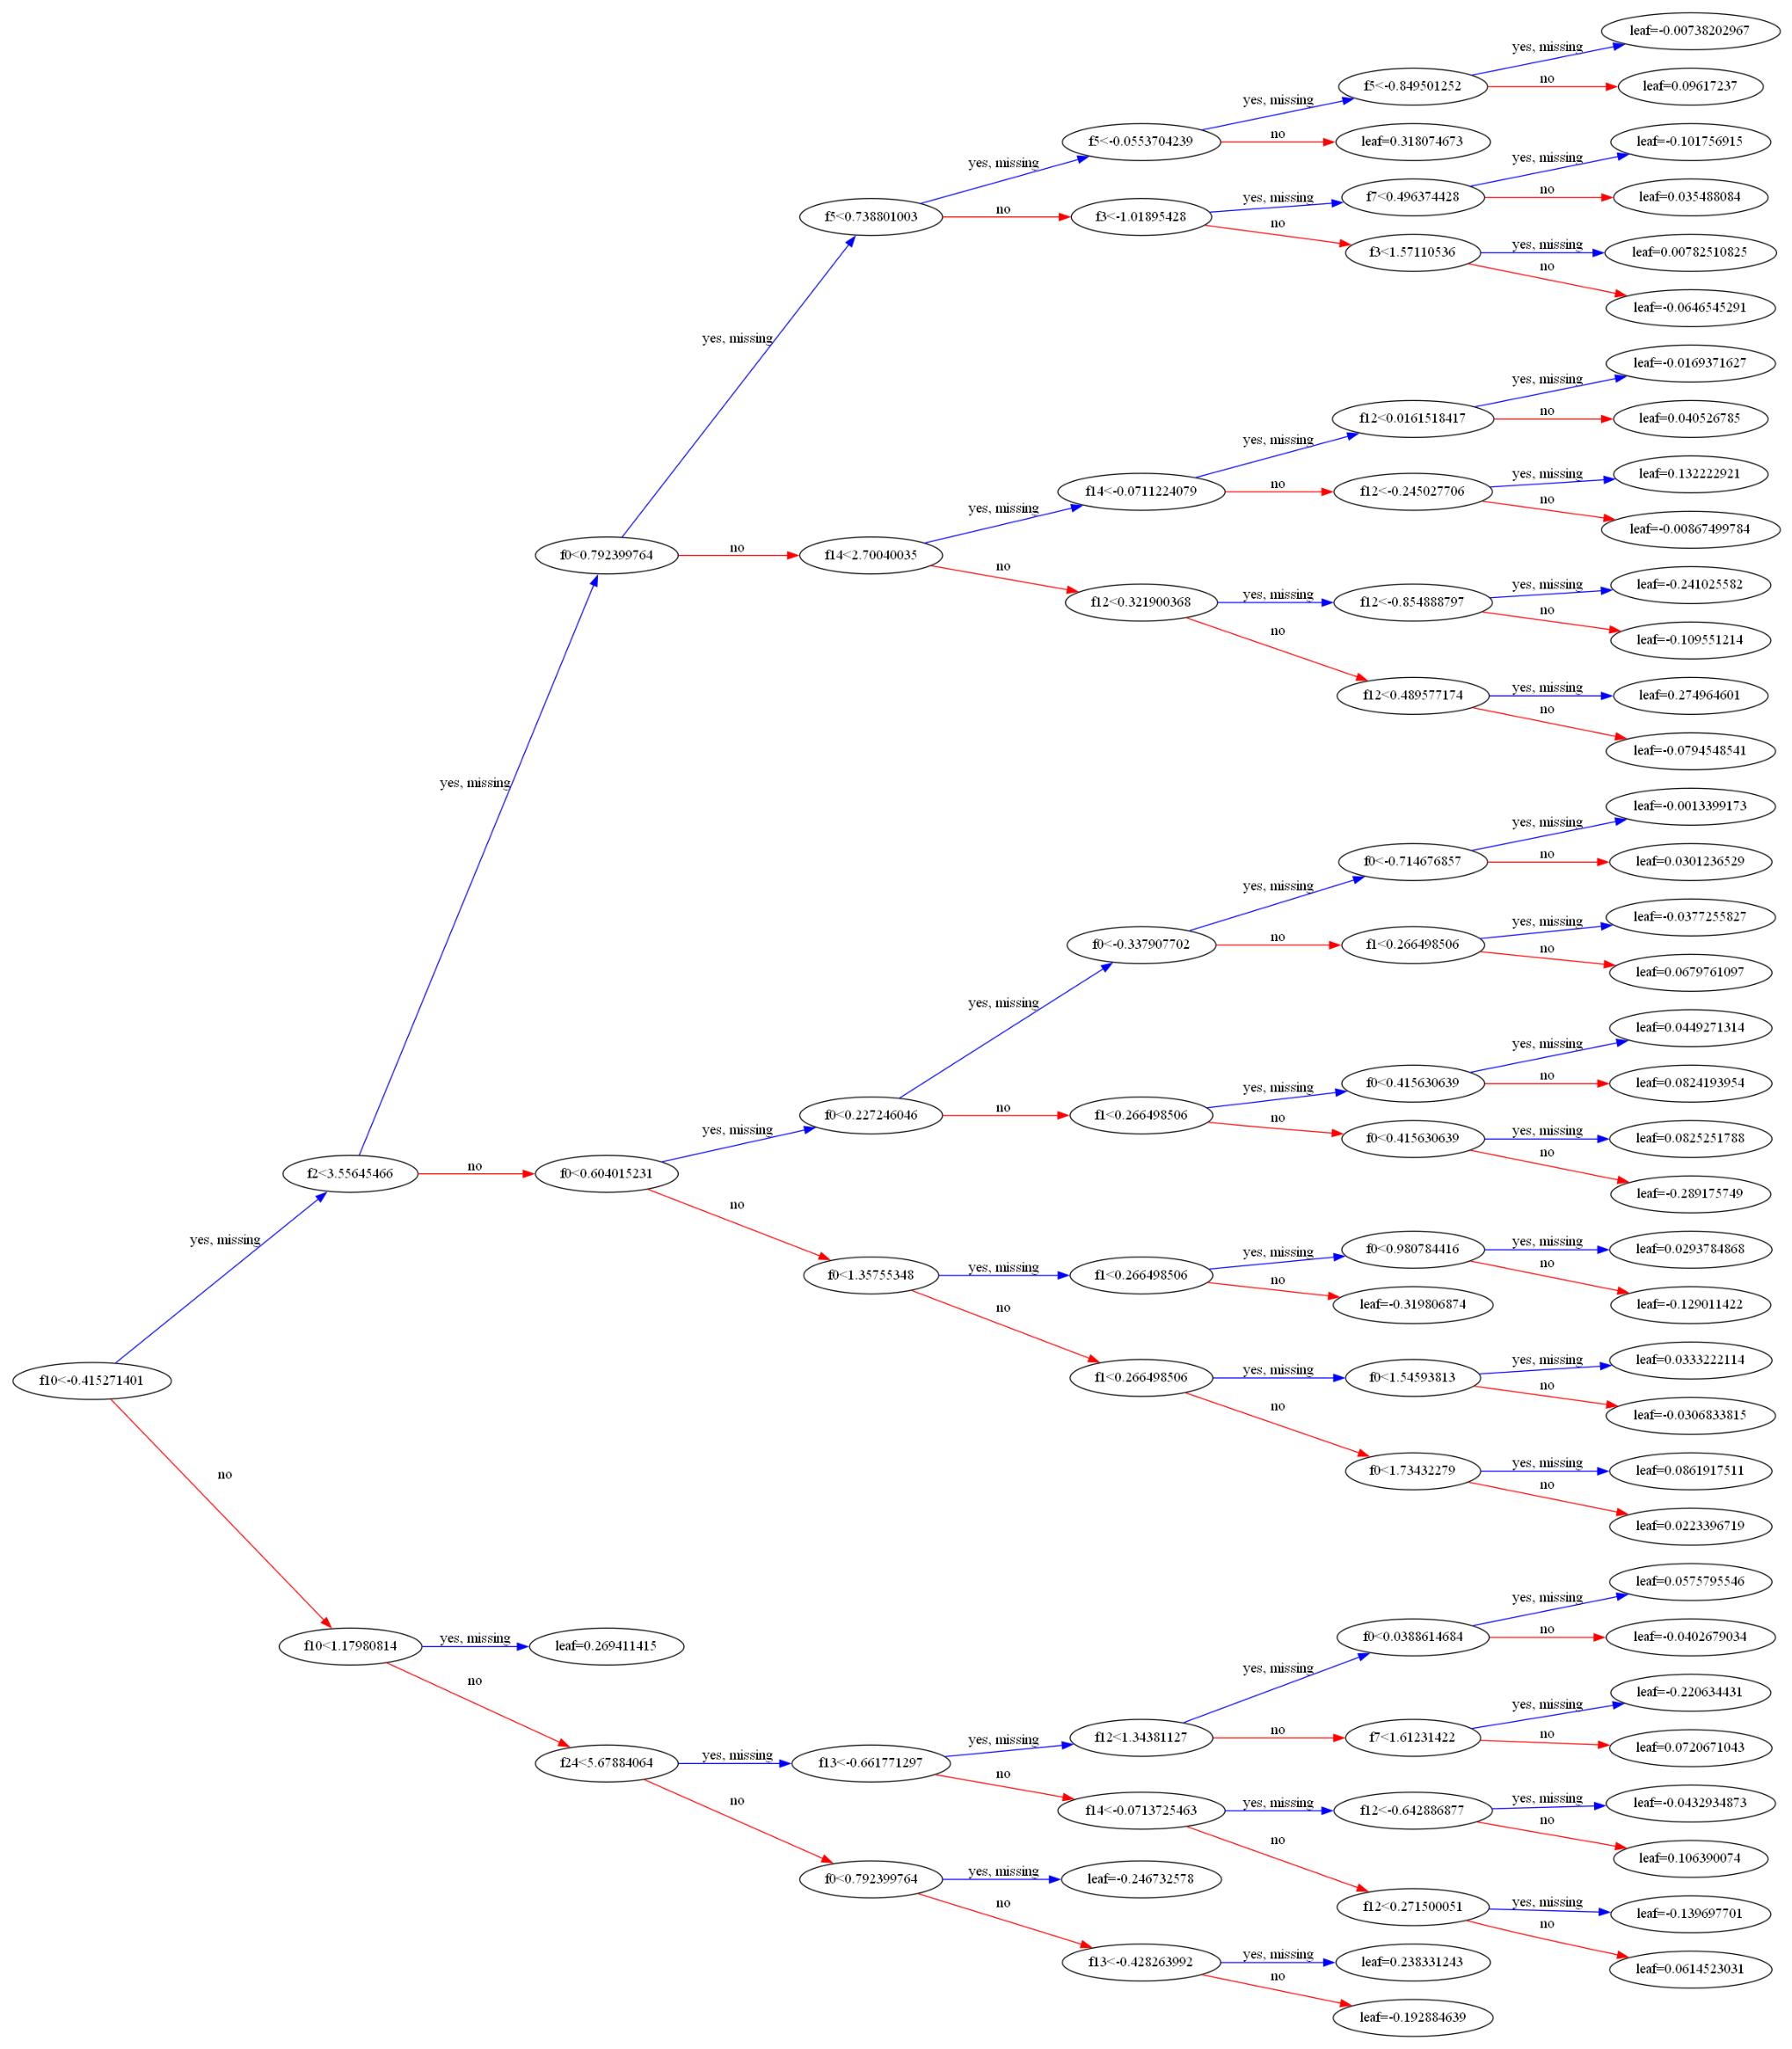

In [17]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(XGB_decisionTree, num_trees=99, ax=ax, rankdir='LR')
plt.show()

In [ ]:
joblib.dump(XGB_decisionTree, 'XGBmodel.pkl')
joblib.dump(scaler, 'XGBscaler.pkl');